# Importing all the library

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical #to transfer the data format from integer to categorical
from keras.callbacks import EarlyStopping  #not to overfit
from keras.models import Sequential #calling CNN
from keras.layers import Dense, Dropout, Activation, Flatten #
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil

#!pip install opencv-python
#!pip3 install --upgrade tensorflow
#shutil.unpack_archive("fer2013.csv.zip")

#print(os.listdir("../input"))

# Loading and Understanding the data

In [16]:
data = pd.read_csv('fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [17]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [18]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [19]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


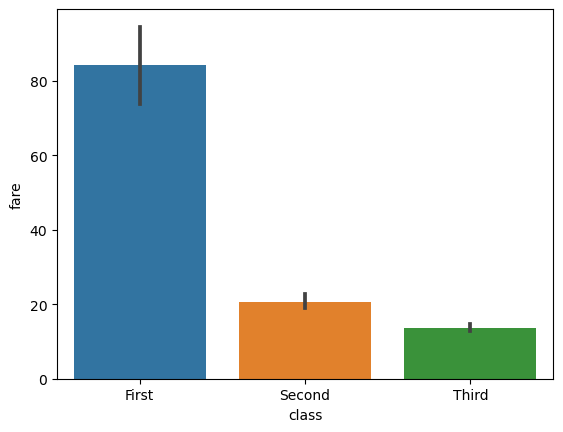

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# read a titanic.csv file
# from seaborn library
df = sns.load_dataset('titanic')
 
# class v / s fare barplot
sns.barplot(x = 'class', y = 'fare', data = df)
 
# Show the plot
plt.show()

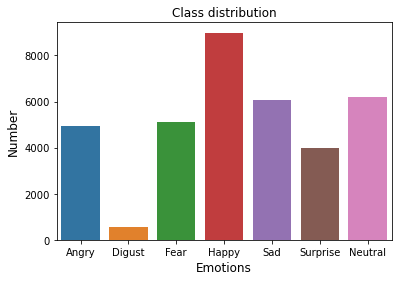

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
 

sns.barplot(x = 'emotion', y = 'number', data = emotion_counts)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()
# Show the plot
plt.show()

# Data pre-processing

C:\Users\Madhurima\AppData\Local\Temp\ipykernel_20424\2815158599.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


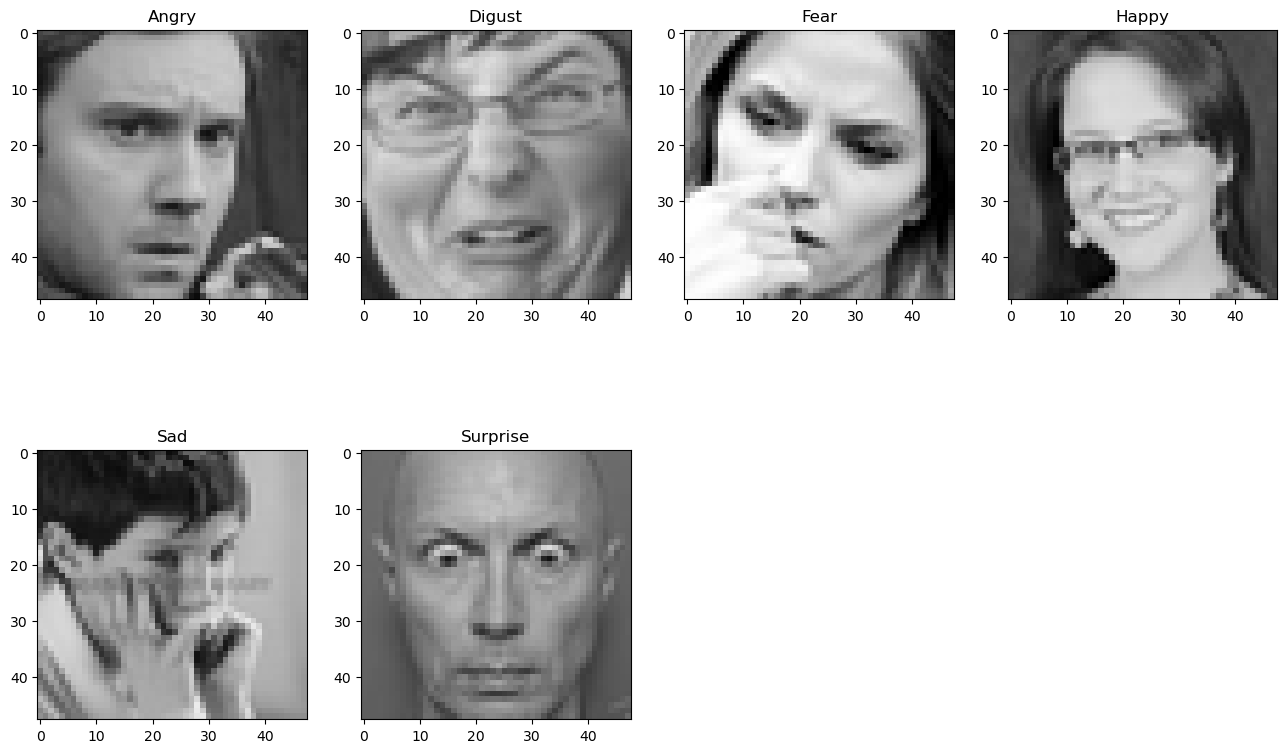

In [21]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,7):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])
    #im1 = img.save("geeks.jpg")
    

plt.show()
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

In [22]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


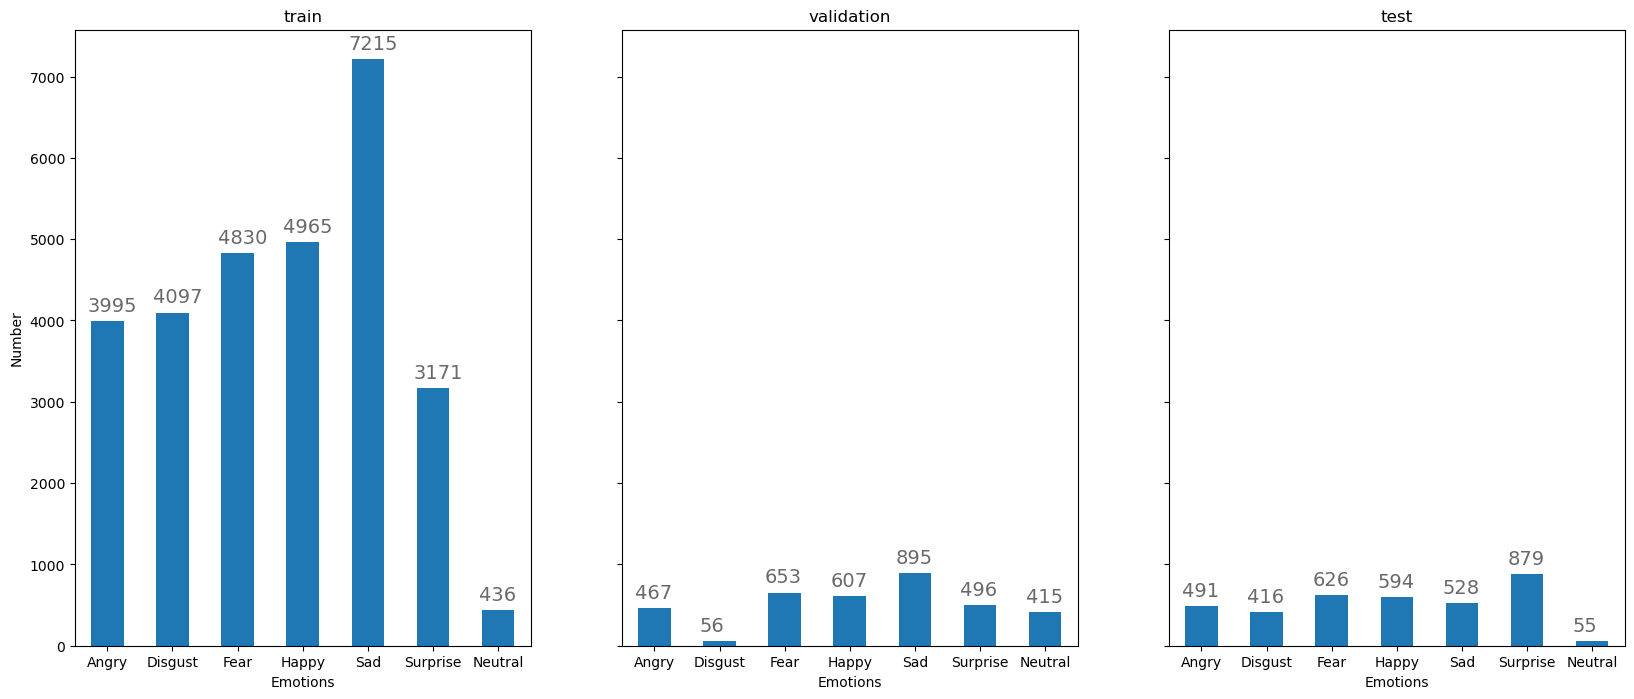

In [23]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [24]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

# Data prep

In [25]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


# Building CNN Model

In [17]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

C:\Users\Madhurima\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training

In [ ]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
448/448 - 4383s - loss: 1.7044 - accuracy: 0.3188 - val_loss: 1.8280 - val_accuracy: 0.2884 - 4383s/epoch - 10s/step
Epoch 2/50
448/448 - 5270s - loss: 1.4303 - accuracy: 0.4427 - val_loss: 1.4659 - val_accuracy: 0.4235 - 5270s/epoch - 12s/step
Epoch 3/50
448/448 - 3772s - loss: 1.2730 - accuracy: 0.5141 - val_loss: 1.3723 - val_accuracy: 0.4851 - 3772s/epoch - 8s/step
Epoch 4/50
448/448 - 8653s - loss: 1.1858 - accuracy: 0.5442 - val_loss: 1.2392 - val_accuracy: 0.5297 - 8653s/epoch - 19s/step
Epoch 5/50
448/448 - 24349s - loss: 1.1273 - accuracy: 0.5701 - val_loss: 1.2885 - val_accuracy: 0.5344 - 24349s/epoch - 54s/step
Epoch 6/50
448/448 - 12512s - loss: 1.0925 - accuracy: 0.5867 - val_loss: 1.4462 - val_accuracy: 0.4703 - 12512s/epoch - 28s/step
Epoch 7/50
448/448 - 17057s - loss: 1.0590 - accuracy: 0.5983 - val_loss: 1.1956 - val_accuracy: 0.5469 - 17057s/epoch - 38s/step
Epoch 8/50
448/448 - 18875s - loss: 1.0341 - accuracy: 0.6063 - val_loss: 1.0480 - val_accuracy: 0.

# Saving the model

In [11]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
from tensorflow import keras
#model.save("my_model")
model.save("model_64.h5")

NameError: name 'model' is not defined

# Loading the model

In [12]:
from tensorflow import keras
emotion_rec_model = keras.models.load_model("model_64.h5")

In [26]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(emotion_rec_model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 145s 1s/step
CNN Model Accuracy on test set: 0.6684


#### The Final Accuracy of CNN Model is  66.84%

# Confusion matrix

In [29]:
from sklearn.metrics import classification_report

print(classification_report(test_true, test_pred, digits=6))

              precision    recall  f1-score   support

           0   0.587302  0.602851  0.594975       491
           1   0.781250  0.454545  0.574713        55
           2   0.579251  0.380682  0.459429       528
           3   0.862375  0.883959  0.873034       879
           4   0.518302  0.595960  0.554424       594
           5   0.744292  0.783654  0.763466       416
           6   0.614035  0.670927  0.641221       626

    accuracy                       0.668431      3589
   macro avg   0.669544  0.624654  0.637323      3589
weighted avg   0.667899  0.668431  0.663709      3589



In [31]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

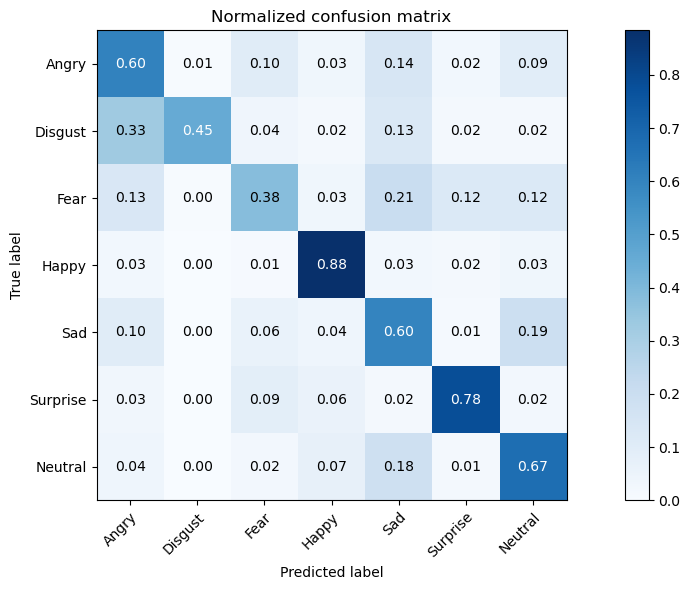

In [32]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()


# Testing

C:\Users\Madhurima\AppData\Local\Temp\ipykernel_20424\3098988782.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


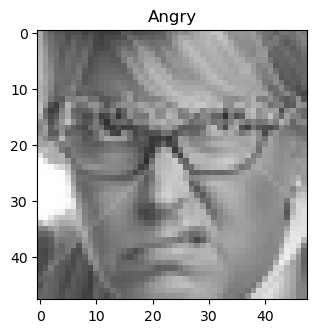

In [33]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels)
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
face = data_test[data_test["emotion"]==0].iloc[0]
#data[data['emotion'] == i-1].iloc[0]
img = row2image(face)
plt.subplot(2,4,i)
plt.imshow(img[0])
plt.title(img[1])

plt.show()

In [35]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

def emotion_detection(df,emotion):
    for i,j in emotion_map.items():
        if j== emotion:
            key=i
  #key=emotion_map[emotion]
    emo_df = df[df["emotion"]==key].head(1)
    test_X, test_Y   = conv(emo_df, "test") #test data
    test_pred = np.argmax(emotion_rec_model.predict(test_X), axis=1)
    plt.figure(0, figsize=(16,10))
    face = df[df["emotion"]==key].head(1).iloc[0]
  #data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

    plt.show()  
    return emotion_map[test_pred[0]]

In [37]:
def conv(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

In [40]:
angry_df = data_test[data_test["emotion"]==0].head(1)

In [41]:
test_X, test_Y   = conv(angry_df, "test") #test data

test _X shape: {},  test _Y shape: (1, 48, 48, 1)


test _X shape: {},  test _Y shape: (1, 48, 48, 1)
1/1 [==============================] - 0s 59ms/step


C:\Users\Madhurima\AppData\Local\Temp\ipykernel_20424\3098988782.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


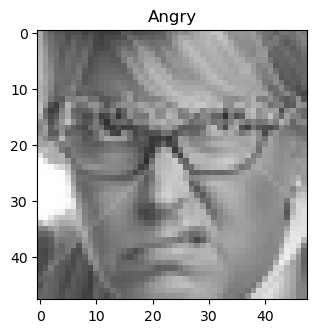

'Angry'

In [43]:
emotion_detection(data_test,"Angry")

# Prediction of Happy

In [45]:
Happy_df = data_test[data_test["emotion"]==3].sample(1)

C:\Users\Madhurima\AppData\Local\Temp\ipykernel_20424\3098988782.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


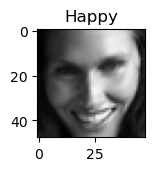

In [46]:
face =Happy_df.iloc[0]
  #data[data['emotion'] == i-1].iloc[0]
img = row2image(face)
plt.subplot(2,4,i)
plt.imshow(img[0])
plt.title(img[1])

plt.show()

In [57]:
#emo_df = df[df["emotion"]==key].head(1)
test_X, test_Y   = conv(Happy_df, "test") #test data
test_pred = np.argmax(emotion_rec_model.predict(test_X), axis=1)

test _X shape: {},  test _Y shape: (1, 48, 48, 1)
1/1 [==============================] - 0s 458ms/step


In [59]:
test_pred

array([3], dtype=int64)

In [58]:
emotion_map[test_pred[0]]

'Happy'

# Prediction of Surprise

In [71]:
Surprise_df = data_test[data_test["emotion"]==5].sample(1)

C:\Users\Madhurima\AppData\Local\Temp\ipykernel_20424\3098988782.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


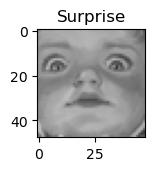

In [72]:
face =Surprise_df.iloc[0]
  #data[data['emotion'] == i-1].iloc[0]
img = row2image(face)
plt.subplot(2,4,i)
plt.imshow(img[0])
plt.title(img[1])

plt.show()

In [73]:
#emo_df = df[df["emotion"]==key].head(1)
test_X, test_Y   = conv(Surprise_df, "test") #test data
test_pred = np.argmax(emotion_rec_model.predict(test_X), axis=1)

test _X shape: {},  test _Y shape: (1, 48, 48, 1)
1/1 [==============================] - 0s 371ms/step


In [74]:
test_pred

array([5], dtype=int64)

In [75]:
emotion_map[test_pred[0]]

'Surprise'

# Prediction of Sad

In [66]:
Sad_df = data_test[data_test["emotion"]==4].sample(1)

C:\Users\Madhurima\AppData\Local\Temp\ipykernel_20424\3098988782.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


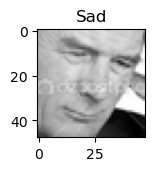

In [67]:
face =Sad_df.iloc[0]
  #data[data['emotion'] == i-1].iloc[0]
img = row2image(face)
plt.subplot(2,4,i)
plt.imshow(img[0])
plt.title(img[1])

plt.show()

In [68]:
#emo_df = df[df["emotion"]==key].head(1)
test_X, test_Y   = conv(Sad_df, "test") #test data
test_pred = np.argmax(emotion_rec_model.predict(test_X), axis=1)

test _X shape: {},  test _Y shape: (1, 48, 48, 1)
1/1 [==============================] - 0s 59ms/step


In [69]:
test_pred

array([4], dtype=int64)

In [70]:
emotion_map[test_pred[0]]

'Sad'

# Prediction of Neutral

In [76]:
Neutral_df = data_test[data_test["emotion"]==6].sample(1)

C:\Users\Madhurima\AppData\Local\Temp\ipykernel_20424\3098988782.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


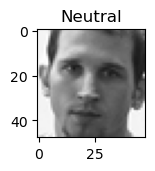

In [77]:
face =Neutral_df.iloc[0]
  #data[data['emotion'] == i-1].iloc[0]
img = row2image(face)
plt.subplot(2,4,i)
plt.imshow(img[0])
plt.title(img[1])

plt.show()

In [78]:
#emo_df = df[df["emotion"]==key].head(1)
test_X, test_Y   = conv(Neutral_df, "test") #test data
test_pred = np.argmax(emotion_rec_model.predict(test_X), axis=1)

test _X shape: {},  test _Y shape: (1, 48, 48, 1)
1/1 [==============================] - 0s 56ms/step


In [79]:
test_pred

array([6], dtype=int64)

In [80]:
emotion_map[test_pred[0]]

'Neutral'